In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
import datetime
import time
import os
import json
import librosa.display
import matplotlib.pyplot as plt

from src.data import NSynthDataset
from src.utils import print_and_log
from src.models import AutoencoderClassifier

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
else:  
    device = torch.device("cpu") 

In [3]:
hparams = {
    'checkpoint' : None,
    'feature_type' : 'mel',
    'instrument_source' : [0, 1, 2],
    'remove_synth_lead' : True,
    'scaling' : 'normalize',
    'resize' : (128, 128),
    'n_epochs' : 25,
    'batch_size' : 64,
    'lr' : 0.00005,
    'hidden_dim' : 128,
    'display_iters' : 100,
    'val_iters' : 1000,
    'n_val_samples' : 1000, 
    'n_early_stopping' : 5 # stop if validation doesn't improve after this number of validation cycles
}

In [4]:
train_dataset = NSynthDataset(
    'data/nsynth/nsynth-train', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling'],
    resize=hparams['resize'],
    include_meta=True,
    remove_synth_lead=hparams['remove_synth_lead']
)

val_dataset = NSynthDataset(
    'data/nsynth/nsynth-valid', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling'],
    resize=hparams['resize'],
    include_meta=True,
    remove_synth_lead=hparams['remove_synth_lead']
)

In [5]:
class_ctr = Counter([x['instrument_family_str'] for x in train_dataset.meta.values()])
class_dict = dict(enumerate(sorted(class_ctr)))
inv_class_dict = dict([(v, k) for k, v in class_dict.items()])
class_weights = np.array([max(class_ctr.values())/class_ctr[class_dict[i]] for i in range(len(class_dict))])

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [7]:
model = AutoencoderClassifier(n_classes=len(class_dict), h_dim=hparams['hidden_dim']).to(device)
print('# of parameters : {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# of parameters : 8400779


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

In [9]:
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')
results_dir = 'train_results/multitask/{}'.format(timestamp)
os.makedirs(results_dir)

with open(os.path.join(results_dir, 'hparams.json'), 'w') as fp:
    json.dump(hparams, fp)

log_file = os.path.join(results_dir, 'train_log.txt')
log = open(log_file, 'w')
log.close()
print_and_log('{}'.format(model.__class__.__name__), log_file)

AutoencoderClassifier


[0,     1] loss : (total - 3.5911, class - 2.3900, recon - 1.2012), acc : 0.1250
[0,   100] loss : (total - 2.5414, class - 1.7627, recon - 0.7787), acc : 0.3594
[0,   200] loss : (total - 2.7133, class - 1.9750, recon - 0.7383), acc : 0.4062
[0,   300] loss : (total - 2.2670, class - 1.6398, recon - 0.6272), acc : 0.3594
[0,   400] loss : (total - 2.2025, class - 1.7059, recon - 0.4966), acc : 0.4062
[0,   500] loss : (total - 1.6868, class - 1.2790, recon - 0.4078), acc : 0.4531
[0,   600] loss : (total - 2.0364, class - 1.6921, recon - 0.3442), acc : 0.2656
[0,   700] loss : (total - 1.6190, class - 1.3276, recon - 0.2914), acc : 0.5625
[0,   800] loss : (total - 1.6807, class - 1.4310, recon - 0.2497), acc : 0.4531
[0,   900] loss : (total - 1.5188, class - 1.2994, recon - 0.2195), acc : 0.4688
[0,  1000] loss : (total - 1.3677, class - 1.1754, recon - 0.1923), acc : 0.5781
Val - loss : (total - 1.6152, class - 1.4231, recon - 0.1922), acc : 0.4551


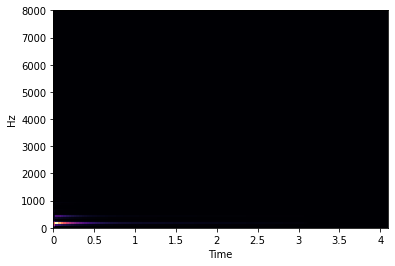

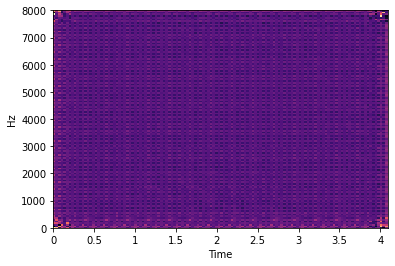

Weights saved in train_results/multitask/20200603-012951/model-1000.weights
[0,  1100] loss : (total - 1.7395, class - 1.5714, recon - 0.1681), acc : 0.3281
[0,  1200] loss : (total - 1.4825, class - 1.3368, recon - 0.1458), acc : 0.4219
[0,  1300] loss : (total - 0.9638, class - 0.8337, recon - 0.1301), acc : 0.6250
[0,  1400] loss : (total - 1.2278, class - 1.1140, recon - 0.1138), acc : 0.5312
[0,  1500] loss : (total - 1.0657, class - 0.9614, recon - 0.1043), acc : 0.5312
[0,  1600] loss : (total - 1.1730, class - 1.0828, recon - 0.0903), acc : 0.5781
[0,  1700] loss : (total - 0.9595, class - 0.8750, recon - 0.0845), acc : 0.6562
[0,  1800] loss : (total - 1.1314, class - 1.0560, recon - 0.0754), acc : 0.6094
[0,  1900] loss : (total - 1.0360, class - 0.9652, recon - 0.0709), acc : 0.6719
[0,  2000] loss : (total - 0.8750, class - 0.8129, recon - 0.0622), acc : 0.6406
Val - loss : (total - 1.5755, class - 1.5112, recon - 0.0644), acc : 0.4648


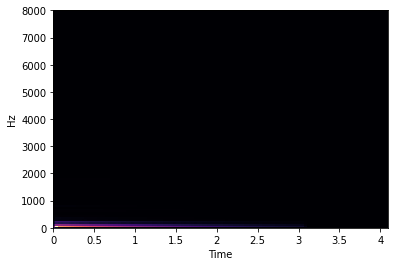

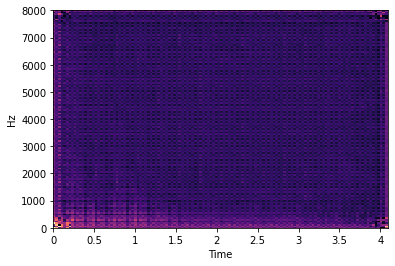

Weights saved in train_results/multitask/20200603-012951/model-2000.weights
[0,  2100] loss : (total - 0.9828, class - 0.9254, recon - 0.0574), acc : 0.6094
[0,  2200] loss : (total - 1.1483, class - 1.0970, recon - 0.0512), acc : 0.6094
[0,  2300] loss : (total - 0.8096, class - 0.7626, recon - 0.0470), acc : 0.7344
[0,  2400] loss : (total - 1.0048, class - 0.9613, recon - 0.0435), acc : 0.5469
[0,  2500] loss : (total - 0.6296, class - 0.5870, recon - 0.0426), acc : 0.7656
[0,  2600] loss : (total - 0.7764, class - 0.7365, recon - 0.0400), acc : 0.7500
[0,  2700] loss : (total - 0.7082, class - 0.6718, recon - 0.0364), acc : 0.7344
[0,  2800] loss : (total - 0.6640, class - 0.6312, recon - 0.0328), acc : 0.7500
[0,  2900] loss : (total - 0.5540, class - 0.5193, recon - 0.0348), acc : 0.8281
[0,  3000] loss : (total - 0.5990, class - 0.5636, recon - 0.0353), acc : 0.7656
Val - loss : (total - 1.9039, class - 1.8667, recon - 0.0372), acc : 0.4316


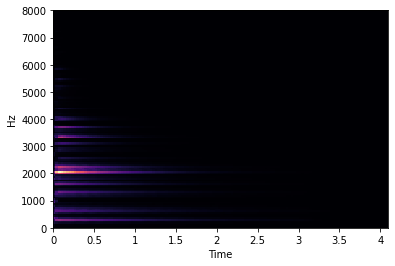

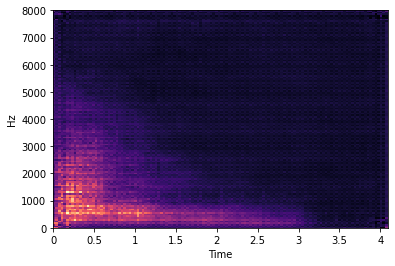

[0,  3100] loss : (total - 0.6061, class - 0.5762, recon - 0.0299), acc : 0.7656
[0,  3200] loss : (total - 0.7491, class - 0.7215, recon - 0.0276), acc : 0.6875
[0,  3300] loss : (total - 0.8133, class - 0.7880, recon - 0.0253), acc : 0.7031
[0,  3400] loss : (total - 0.6756, class - 0.6491, recon - 0.0265), acc : 0.7188
[0,  3500] loss : (total - 0.7388, class - 0.7141, recon - 0.0247), acc : 0.6875
[0,  3600] loss : (total - 0.5707, class - 0.5447, recon - 0.0260), acc : 0.7344
[0,  3700] loss : (total - 0.6895, class - 0.6648, recon - 0.0247), acc : 0.7031
[0,  3800] loss : (total - 0.5540, class - 0.5297, recon - 0.0243), acc : 0.7812
[0,  3900] loss : (total - 0.8104, class - 0.7825, recon - 0.0279), acc : 0.7188
[0,  4000] loss : (total - 0.5339, class - 0.5111, recon - 0.0228), acc : 0.7656
Val - loss : (total - 1.1569, class - 1.1295, recon - 0.0274), acc : 0.6318


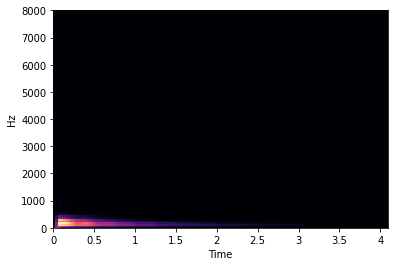

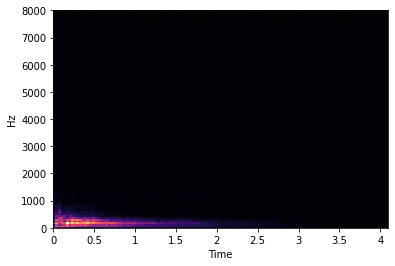

Weights saved in train_results/multitask/20200603-012951/model-4000.weights
[0,  4100] loss : (total - 0.5635, class - 0.5402, recon - 0.0232), acc : 0.7656
[0,  4200] loss : (total - 0.4874, class - 0.4638, recon - 0.0236), acc : 0.7656
[0,  4300] loss : (total - 0.7019, class - 0.6842, recon - 0.0177), acc : 0.6406
[0,  4400] loss : (total - 0.4757, class - 0.4563, recon - 0.0194), acc : 0.8281
[1,  4500] loss : (total - 0.2636, class - 0.2395, recon - 0.0240), acc : 0.9062
[1,  4600] loss : (total - 0.3061, class - 0.2790, recon - 0.0271), acc : 0.8438
[1,  4700] loss : (total - 0.3229, class - 0.2989, recon - 0.0240), acc : 0.8438
[1,  4800] loss : (total - 0.7586, class - 0.7415, recon - 0.0171), acc : 0.7656
[1,  4900] loss : (total - 0.4536, class - 0.4346, recon - 0.0191), acc : 0.7969
[1,  5000] loss : (total - 0.3055, class - 0.2857, recon - 0.0198), acc : 0.8438
Val - loss : (total - 2.5100, class - 2.4864, recon - 0.0236), acc : 0.2910


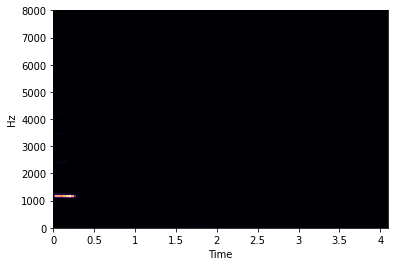

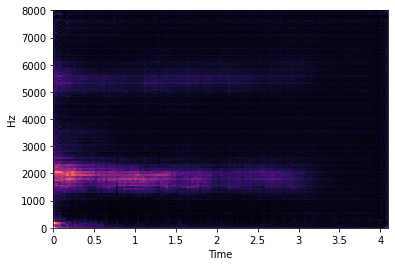

[1,  5100] loss : (total - 0.3218, class - 0.3018, recon - 0.0201), acc : 0.8594
[1,  5200] loss : (total - 0.4056, class - 0.3846, recon - 0.0210), acc : 0.8594
[1,  5300] loss : (total - 0.3613, class - 0.3429, recon - 0.0184), acc : 0.8594
[1,  5400] loss : (total - 0.4237, class - 0.4045, recon - 0.0192), acc : 0.8281
[1,  5500] loss : (total - 0.4527, class - 0.4334, recon - 0.0193), acc : 0.7969
[1,  5600] loss : (total - 0.4238, class - 0.4056, recon - 0.0182), acc : 0.8438
[1,  5700] loss : (total - 0.4058, class - 0.3859, recon - 0.0199), acc : 0.8281
[1,  5800] loss : (total - 0.3576, class - 0.3377, recon - 0.0199), acc : 0.8594
[1,  5900] loss : (total - 0.4950, class - 0.4751, recon - 0.0200), acc : 0.7500
[1,  6000] loss : (total - 0.2533, class - 0.2362, recon - 0.0171), acc : 0.9062
Val - loss : (total - 4.7733, class - 4.7339, recon - 0.0394), acc : 0.1650


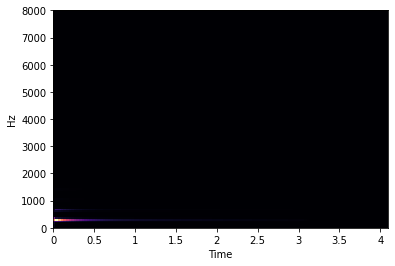

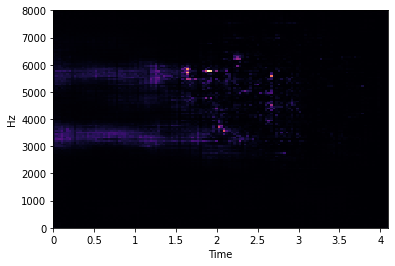

[1,  6100] loss : (total - 0.2189, class - 0.2032, recon - 0.0158), acc : 0.9531
[1,  6200] loss : (total - 0.3727, class - 0.3595, recon - 0.0131), acc : 0.8906
[1,  6300] loss : (total - 0.4823, class - 0.4610, recon - 0.0213), acc : 0.8281
[1,  6400] loss : (total - 0.3037, class - 0.2851, recon - 0.0185), acc : 0.9062
[1,  6500] loss : (total - 0.3042, class - 0.2878, recon - 0.0164), acc : 0.8438
[1,  6600] loss : (total - 0.2433, class - 0.2267, recon - 0.0166), acc : 0.8906
[1,  6700] loss : (total - 0.3352, class - 0.3207, recon - 0.0145), acc : 0.9062
[1,  6800] loss : (total - 0.3375, class - 0.3199, recon - 0.0176), acc : 0.8281
[1,  6900] loss : (total - 0.3735, class - 0.3572, recon - 0.0163), acc : 0.8750
[1,  7000] loss : (total - 0.4155, class - 0.3983, recon - 0.0172), acc : 0.8125
Val - loss : (total - 4.6326, class - 4.5889, recon - 0.0438), acc : 0.1621


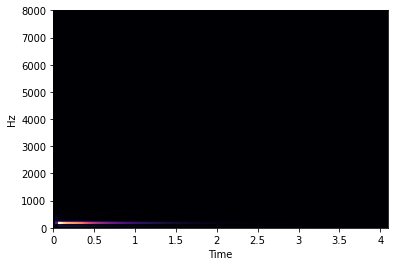

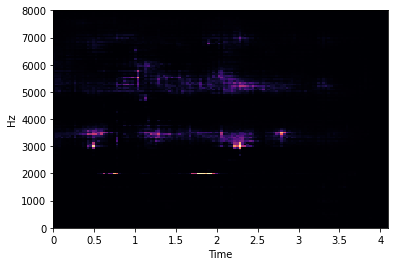

[1,  7100] loss : (total - 0.3260, class - 0.3094, recon - 0.0166), acc : 0.8906
[1,  7200] loss : (total - 0.4283, class - 0.4094, recon - 0.0190), acc : 0.8750
[1,  7300] loss : (total - 0.1531, class - 0.1345, recon - 0.0186), acc : 0.9531
[1,  7400] loss : (total - 0.2309, class - 0.2133, recon - 0.0176), acc : 0.8438
[1,  7500] loss : (total - 0.2357, class - 0.2211, recon - 0.0146), acc : 0.8750
[1,  7600] loss : (total - 0.3034, class - 0.2862, recon - 0.0171), acc : 0.8750
[1,  7700] loss : (total - 0.2786, class - 0.2639, recon - 0.0147), acc : 0.8906
[1,  7800] loss : (total - 0.2774, class - 0.2605, recon - 0.0169), acc : 0.8750
[1,  7900] loss : (total - 0.1333, class - 0.1160, recon - 0.0173), acc : 0.9688
[1,  8000] loss : (total - 0.1705, class - 0.1505, recon - 0.0201), acc : 0.9844
Val - loss : (total - 9.5432, class - 9.4451, recon - 0.0981), acc : 0.1182


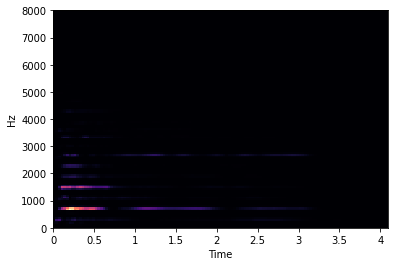

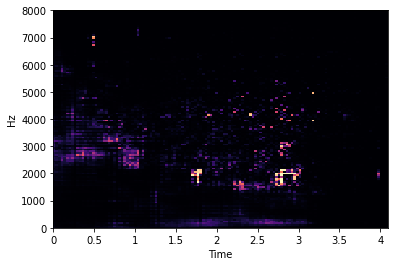

[1,  8100] loss : (total - 0.3255, class - 0.3112, recon - 0.0143), acc : 0.8281
[1,  8200] loss : (total - 0.3855, class - 0.3697, recon - 0.0159), acc : 0.8438
[1,  8300] loss : (total - 0.3148, class - 0.2972, recon - 0.0176), acc : 0.8750
[1,  8400] loss : (total - 0.2610, class - 0.2422, recon - 0.0188), acc : 0.9062
[1,  8500] loss : (total - 0.3415, class - 0.3259, recon - 0.0156), acc : 0.8125
[1,  8600] loss : (total - 0.4004, class - 0.3857, recon - 0.0147), acc : 0.8750
[1,  8700] loss : (total - 0.3084, class - 0.2901, recon - 0.0183), acc : 0.8438
[1,  8800] loss : (total - 0.2118, class - 0.1947, recon - 0.0171), acc : 0.9062
[2,  8900] loss : (total - 0.3185, class - 0.3045, recon - 0.0140), acc : 0.9062
[2,  9000] loss : (total - 0.2813, class - 0.2637, recon - 0.0176), acc : 0.8594
Val - loss : (total - 1.3478, class - 1.3270, recon - 0.0209), acc : 0.6357


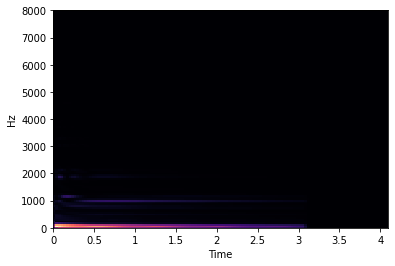

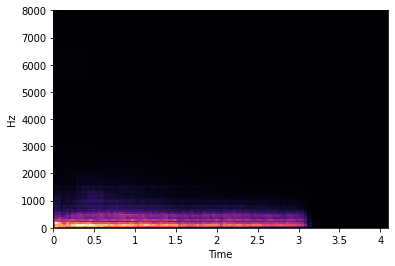

Early stopping... training complete


In [10]:
recon_loss_fn = nn.BCELoss()
class_loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32, device=device))

ckpt_weights_path = None
best_loss = 1e10
since_best = 0
done = False

if hparams['checkpoint']:
    print_and_log('Resuming training from {}'.format(hparams['checkpoint']), log_file)
    ckpt = torch.load(hparams['checkpoint'])
    epoch = ckpt['epoch']
    itr = ckpt['itr']
    optimizer.load_state_dict(ckpt['optimizer'])
    model.load_state_dict(ckpt['model'])
    best_loss = ckpt['best_loss']
else:
    epoch = 0
    itr = 0

for epoch in range(epoch, hparams['n_epochs']):
    if done:
        break
        
    for batch in train_dataloader:
        if done:
            break
            
        itr += 1
        features = batch[0].unsqueeze(1).to(device)
        labels = torch.tensor([inv_class_dict[i] for i in batch[1]['instrument_family_str']], 
                              dtype=torch.long, device=device)
        logits, recon = model(features)
        
        class_loss = class_loss_fn(logits, labels)
        recon_loss = recon_loss_fn(recon, features)
        loss = class_loss + recon_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (itr % hparams['display_iters'] == 0) or (itr == 1):
            acc = (logits.argmax(-1) == labels).float().mean()
            print_and_log('[{}, {:5d}] loss : (total - {:.4f}, class - {:.4f}, recon - {:.4f}), acc : {:.4f}'\
                          .format(epoch, itr, loss.item(), class_loss.item(), recon_loss.item(), acc.item()), log_file)
            
        if itr % hparams['val_iters'] == 0:
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)
            
            model.eval()
            
            ct, i, val_loss, val_class_loss, val_recon_loss, val_acc = 0, 0, 0.0, 0.0, 0.0, 0.0
            for batch in val_dataloader:
                i += 1
                ct += batch[0].size(0)
                features = batch[0].unsqueeze(1).to(device)
                labels = torch.tensor([inv_class_dict[i] for i in batch[1]['instrument_family_str']], 
                                      dtype=torch.long, device=device)
                logits, recon = model(features)
                
                class_loss = class_loss_fn(logits, labels)
                recon_loss = recon_loss_fn(recon, features)
                loss = class_loss + recon_loss
                acc = (logits.argmax(-1) == labels).float().mean()
                
                val_loss += (loss.item() - val_loss)/i
                val_class_loss += (class_loss.item() - val_class_loss)/i
                val_recon_loss += (recon_loss.item() - val_recon_loss)/i
                val_acc += (acc.item() - val_acc)/i
                
                if ct >= hparams['n_val_samples']:
                    break
                
            print_and_log('Val - loss : (total - {:.4f}, class - {:.4f}, recon - {:.4f}), acc : {:.4f}'\
                          .format(val_loss, val_class_loss, val_recon_loss, val_acc), log_file)
            
            librosa.display.specshow(features[0][0].cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
            plt.show()
            librosa.display.specshow(recon[0][0].detach().cpu().numpy(), sr=16000, x_axis='time', y_axis='hz')
            plt.show()
            
            if val_loss < best_loss:
                since_best = 0
                best_loss = val_loss
                
                # save weights
                if ckpt_weights_path:
                    os.remove(ckpt_weights_path)
                ckpt_weights_path = os.path.join(results_dir, 'model-{}.weights'.format(itr))
                torch.save(model.state_dict(), ckpt_weights_path)
                print_and_log('Weights saved in {}'.format(ckpt_weights_path), log_file)
                
                # save meta information
                ckpt_meta_path = os.path.join(results_dir, 'checkpoint')
                torch.save({
                    'best_loss' : best_loss,
                    'epoch' : epoch,
                    'itr' : itr,
                    'optimizer' : optimizer.state_dict(),
                    'model' : model.state_dict()
                }, ckpt_meta_path)
            else:
                since_best += 1
                if since_best >= hparams['n_early_stopping']:
                    done = True
                    print_and_log('Early stopping... training complete', log_file)
            
            model.train()